In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta

In [56]:
position_path = "./Data/2020-09-29/"
data_path = "./Data/2020-09-29/CR6Data/"
output_path ="./"

df_pos = pd.read_excel(position_path+"FullTestRun_1.xlsx", header=None)
df_pos.columns = ['TIMESTAMP', 'X', 'Y', 'THETA']



'''Create proper timestamps for position'''
dict ={}
for i in tqdm(range(len(df_pos))):
    dict[i]={'TIMESTAMP': datetime.fromordinal(int(df_pos['TIMESTAMP'][i])) + timedelta(days=df_pos['TIMESTAMP'][i]%1) - timedelta(days = 366),'X':df_pos['X'][i],'Y':df_pos['Y'][i],'THETA':df_pos['THETA'][i]}
df_pos = pd.DataFrame.from_dict(dict, "index")



'''Create single CR6 dataframe with datetime for comparisons'''
dict={}
for i in tqdm(range(5339,5392)): #create dataframe of all CR6 data
    outputsize = len(dict)
    
    df_CR6 = pd.read_table(data_path+"Younng10Hz"+str(i)+".dat",
                       sep=",",
                      skiprows=[0,2,3])

    for j in range(len(df_CR6)):
        if "." in df_CR6['TIMESTAMP'][j]:
            date = datetime.strptime(df_CR6['TIMESTAMP'][j], '%Y-%m-%d %H:%M:%S.%f')
            #print(date)
        else:
            date = datetime.strptime(df_CR6['TIMESTAMP'][j], '%Y-%m-%d %H:%M:%S')
            
        #dict[outputsize+j]={"Year":date.year,"Month":date.month,"Day":date.day,"Hour":date.hour,"Minute":date.minute,"Second":date.second+date.microsecond/1000000.,"Record":df_CR6['RECORD'][j],"U (m s^-1)":df_CR6['U'][j],"V (m s^-1)":df_CR6['V'][j],"W (m s^-1)":df_CR6['W'][j],"TSonic (K)":df_CR6['TSonic'][j],"RH (%)":df_CR6['RH'][j],"T_HMP60 (C)":df_CR6['T_HMP60'][j]}
        dict[outputsize+j]={"TIMESTAMP":date,"Record":df_CR6['RECORD'][j],"U (m s^-1)":df_CR6['U'][j],"V (m s^-1)":df_CR6['V'][j],"W (m s^-1)":df_CR6['W'][j],"TSonic (K)":df_CR6['TSonic'][j],"RH (%)":df_CR6['RH'][j],"T_HMP60 (C)":df_CR6['T_HMP60'][j]}    
            
        #output.loc[outputsize+j,output.columns]=[date.year,date.month,date.day,date.hour,date.minute,date.second+date.microsecond,df_CR6['RECORD'][j],df_CR6['U'][j],df_CR6['V'][j],df_CR6['W'][j],df_CR6['TSonic'][j],df_CR6['RH'][j],df_CR6['T_HMP60'][j]]
        #output = output.append(pd.Series([date.year,date.month,date.day,date.hour,date.minute,date.second+date.microsecond/1000000.,df_CR6['RECORD'][j],df_CR6['U'][j],df_CR6['V'][j],df_CR6['W'][j],df_CR6['TSonic'][j],df_CR6['RH'][j],df_CR6['T_HMP60'][j]], index=output.columns ), ignore_index=True)
    
df_CR6 = pd.DataFrame.from_dict(dict, "index")




'''Trim CR6 data based on timestamps from position data'''
#print((df_CR6['TIMESTAMP']-df_pos['TIMESTAMP'].iloc[0]).abs().argsort()[:2].iloc[0])
#print((df_CR6['TIMESTAMP']-df_pos['TIMESTAMP'].iloc[-1]).abs().argsort()[:2].iloc[1])

for i in tqdm(range((df_CR6['TIMESTAMP']-df_pos['TIMESTAMP'].iloc[-1]).abs().argsort()[:2].iloc[1],len(df_CR6))):
    df_CR6.drop(i, inplace=True)

for i in tqdm(range(0,(df_CR6['TIMESTAMP']-df_pos['TIMESTAMP'].iloc[0]).abs().argsort()[:2].iloc[0])):
    df_CR6.drop(i, inplace=True)
    
df_CR6.reset_index(inplace=True, drop=True)


'''Create a combined database'''
dict={}
for i in tqdm(range(len(df_CR6))):
    date = df_CR6["TIMESTAMP"].iloc[i]
    index = (df_pos['TIMESTAMP']-date).abs().argsort()[:2].iloc[1]
    
    x = df_pos['X'].iloc[index]
    y = df_pos['Y'].iloc[index]
    theta = df_pos['THETA'].iloc[index]
    
    dict[i]= {"Year":date.year,"Month":date.month,"Day":date.day,"Hour":date.hour,
              "Minute":date.minute,"Second":date.second+date.microsecond/1000000.,
              "x":x,"y":y,"theta":theta,
              "Record":df_CR6['Record'][i],"U (m s^-1)":df_CR6['U (m s^-1)'][i],"V (m s^-1)":df_CR6['V (m s^-1)'][i],
              "W (m s^-1)":df_CR6['W (m s^-1)'][i],"TSonic (K)":df_CR6['TSonic (K)'][i],"RH (%)":df_CR6['RH (%)'][i],
              "T_HMP60 (C)":df_CR6['T_HMP60 (C)'][i]}

    
df_comb = pd.DataFrame.from_dict(dict, "index")


'''Create MultiIndex based on each point'''
point_dict={'p1':[2.8,0.7,0], 'p2':[6.0,0.7,0], 'p3':[6.0,4.4,0], 'p4':[2.8,4.4,0],
           'p5':[6.0,7.9,0], 'p6':[2.8,7.9,0], 'p7':[6.0,10.6,0], 'p8':[4.9,11.8,0]}

drop=20 #frequency*seconds to drop, make sure the robot is in the correct positon

dict={'p1':{},'p2':{},'p3':{},'p4':{},'p5':{},'p6':{},'p7':{},'p8':{}}

for i in tqdm(range(drop, len(df_comb))):
    if ([df_comb['x'].iloc[i-drop],df_comb['y'].iloc[i-drop],df_comb['theta'].iloc[i-drop]] and
       [df_comb['x'].iloc[i],df_comb['y'].iloc[i],df_comb['theta'].iloc[i]]) in point_dict.values(): #Check that it has been there for a while
        
        point = list(point_dict.keys())[list(point_dict.values()).index([df_comb['x'].iloc[i],df_comb['y'].iloc[i],df_comb['theta'].iloc[i]])]
                
        dict[point][i]=df_comb.iloc[i].to_dict()
    
        
dict_of_df = {k: pd.DataFrame(v) for k,v in dict.items()}
output = pd.concat(dict_of_df, axis=1).transpose()

  3%|██▏                                                                           | 101/3528 [00:00<00:06, 499.34it/s]

10640
28272


100%|██████████████████████████████████████████████████████████████████████████| 17612/17612 [00:03<00:00, 4811.82it/s]


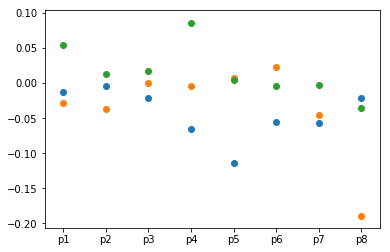

In [96]:
keys=['p1','p2','p3','p4','p5','p6','p7','p8']

plt.scatter(keys,[np.average(output['U (m s^-1)'].loc[i]) for i in keys])
plt.scatter(keys,[np.average(output['V (m s^-1)'].loc[i]) for i in keys])
plt.scatter(keys,[np.average(output['W (m s^-1)'].loc[i]) for i in keys])

plt.show()



In [63]:
  [print(i) for i in range(1,9)]

1
2
3
4
5
6
7
8


[None, None, None, None, None, None, None, None]

In [78]:
output.index.get_level_values(0)

Index(['p1', 'p1', 'p1', 'p1', 'p1', 'p1', 'p1', 'p1', 'p1', 'p1',
       ...
       'p8', 'p8', 'p8', 'p8', 'p8', 'p8', 'p8', 'p8', 'p8', 'p8'],
      dtype='object', length=16245)

In [86]:
[np.average(output['U (m s^-1)'].loc[i]) for i in keys]
           

[-0.00430803351404633,
 -0.021422888015717095,
 -0.11424149827501232,
 -0.05484137931034483,
 -0.06521467257508617,
 -0.057245812807881775,
 -0.013321340561853131,
 -0.021337764647956673]